# Capstone 3 Model Comparison

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import Image
%matplotlib inline

In [2]:
#need to change working directory to data, where the raw data are saved
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\"
os.chdir(path)

In [3]:
# load the data files to compare visually
arima13_avg = pd.read_csv('ARMA averages.csv')
varma23_avg = pd.read_csv('VARMA23_averages.csv')
ses_avg = pd.read_csv('SES_averages.csv')
hwes_avg = pd.read_csv('HWES_averages.csv')

In [4]:
arima13_avg.head(2)

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,125901,median,1,zillow
1,1996-02-29,z_median_OneBR,125829,median,1,zillow


In [5]:
# subset to prediction datasets
def pred_avg_sub(df, model_name, source):
    df_sub = df[df['Source'].str.contains(source)]
    # change the Source to VARMAX pred/fc
    df_sub['Source'] = df_sub['Source'].apply(lambda x: (model_name + ' ' +source))
    df_sub['Date'] = pd.to_datetime(df_sub.Date)
    return df_sub

In [6]:
# get the avg dfs pred sub
a13_pavg = pred_avg_sub(arima13_avg, 'ARMA13', 'prediction')
v23_pavg = pred_avg_sub(varma23_avg, 'VARMA23', 'prediction')
ses_pavg = pred_avg_sub(ses_avg, 'SES', 'prediction')
hwes_pavg = pred_avg_sub(hwes_avg, 'HWES', 'prediction')
# get the avg dfs fc sub
a13_favg = pred_avg_sub(arima13_avg, 'ARMA13', 'forecast')
v23_favg = pred_avg_sub(varma23_avg, 'VARMA23', 'forecast')
ses_favg = pred_avg_sub(ses_avg, 'SES', 'forecast')
hwes_favg = pred_avg_sub(hwes_avg, 'HWES', 'forecast')

In [7]:
# check prediction and forecast dates
def date_check(df, source):
    df_pred = df[df['Source'].str.contains(source)]
    p_name = df_pred.Source.unique()[0]
    p_start = df_pred.Date.unique()[0]
    p_end = df_pred.Date.unique()[-1]
    print(p_name + ' starts on ' + str(p_start) + ' ends on ' + str(p_end))
    print('')

In [8]:
# check the prediction dates
for i in [a13_pavg, v23_pavg, ses_pavg, hwes_pavg]:
    date_check(i, 'prediction')

ARMA13 prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

VARMA23 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2021-01-31T00:00:00.000000000

SES prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

HWES prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000



In [9]:
# let's drop all but VARMA23's first prediction
a13_pavg = a13_pavg[a13_pavg['Date']!=a13_pavg.Date.unique()[0]]
ses_pavg = ses_pavg[ses_pavg['Date']!=ses_pavg.Date.unique()[0]]
hwes_pavg = hwes_pavg[hwes_pavg['Date']!=hwes_pavg.Date.unique()[0]]
# drop VARMA23's last prediction
v23_pavg = v23_pavg[v23_pavg['Date']!=v23_pavg.Date.unique()[-1]]

In [10]:
# check the prediction dates again
for i in [a13_pavg, v23_pavg, ses_pavg, hwes_pavg]:
    date_check(i, 'prediction')

ARMA13 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

VARMA23 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

SES prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

HWES prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000



In [12]:
# check the forecast dates
for i in [a13_favg, v23_favg, ses_favg, hwes_favg]:
    date_check(i, 'forecast')

ARMA13 forecast starts on 2020-12-31T00:00:00.000000000 ends on 2025-12-31T00:00:00.000000000

VARMA23 forecast starts on 2020-12-31T00:00:00.000000000 ends on 2025-12-31T00:00:00.000000000

SES forecast starts on 2020-12-31T00:00:00.000000000 ends on 2025-12-31T00:00:00.000000000

HWES forecast starts on 2020-12-31T00:00:00.000000000 ends on 2025-12-31T00:00:00.000000000



In [13]:
# get the zillow avg
z_avg = arima13_avg[arima13_avg['Source']=='zillow']

In [19]:
# concat all avgs so we can use seaborn to plot
avg_df = pd.concat([z_avg, a13_pavg, v23_pavg, ses_pavg, hwes_pavg, a13_favg, v23_favg, ses_favg, hwes_favg])

In [20]:
avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6272 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          6272 non-null   object
 1   variable      6272 non-null   object
 2   value         6272 non-null   int64 
 3   measure_type  6272 non-null   object
 4   Bedrooms      6272 non-null   int64 
 5   Source        6272 non-null   object
dtypes: int64(2), object(4)
memory usage: 343.0+ KB


In [21]:
avg_df['Date'] = pd.to_datetime(avg_df.Date)

In [22]:
#need to change working directory to figures to save figures
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\"
os.chdir(path)

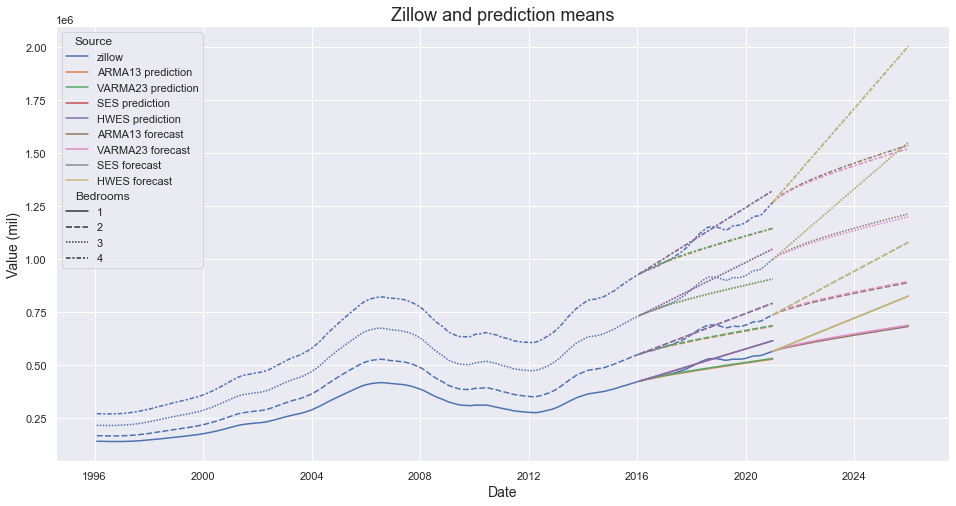

In [23]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = avg_df[avg_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and prediction means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('model_comp_means')

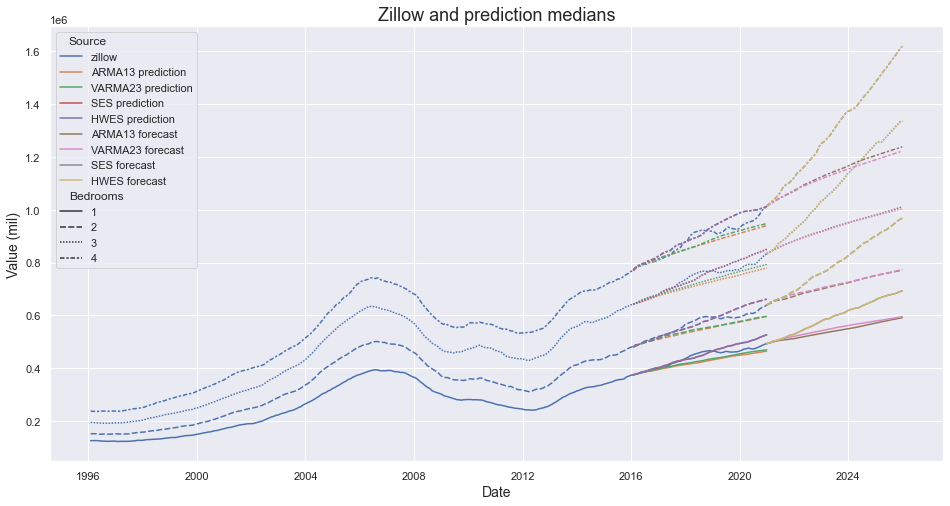

In [24]:
# plot the medians using seaborn
sns.set_theme(style="darkgrid")
sea_median = avg_df[avg_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_median, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and prediction medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('model_comp_medians')

Let's get the model scores and see.

In [26]:
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\"
os.chdir(path)
arima13 = pd.read_csv('CA_house_value_a_est.csv')
varma23 = pd.read_csv('CA_house_value_v23_est.csv')
ses = pd.read_csv('CA_house_value_s_est.csv')
hwes = pd.read_csv('CA_house_value_h_est.csv')

In [27]:
arima13.head()

,Zipcode,County,Date,Value,Bedrooms,Source
0,90004,Los Angeles County,1996-01-31,141542,1,zillow
1,90004,Los Angeles County,1996-01-31,175380,2,zillow
2,90004,Los Angeles County,1996-01-31,124140,3,zillow
3,90004,Los Angeles County,1996-01-31,137079,4,zillow
4,90007,Los Angeles County,1996-01-31,90619,1,zillow


In [28]:
# subset to predicitons
a13 = pred_avg_sub(arima13, 'ARMA13', 'prediction')
v23 = pred_avg_sub(varma23, 'VARMA23', 'prediction')
ses = pred_avg_sub(ses, 'SES', 'prediction')
hwes = pred_avg_sub(hwes, 'HWES', 'prediction')

In [29]:
# check the prediction dates
for i in [a13, v23, ses, hwes]:
    date_check(i, 'prediction')

ARMA13 prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

VARMA23 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2021-01-31T00:00:00.000000000

SES prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

HWES prediction starts on 2015-12-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000



In [30]:
# remove first date on all but VARMA23
a13 = a13[a13['Date']!=a13.Date.unique()[0]]
ses = ses[ses['Date']!=ses.Date.unique()[0]]
hwes = hwes[hwes['Date']!=hwes.Date.unique()[0]]
#  remove 2021 on VARMA23
v23 = v23[v23['Date']!=v23.Date.unique()[-1]]

In [31]:
# check the prediction dates again
for i in [a13, v23, ses, hwes]:
    date_check(i, 'prediction')

ARMA13 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

VARMA23 prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

SES prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000

HWES prediction starts on 2016-01-31T00:00:00.000000000 ends on 2020-12-31T00:00:00.000000000



In [32]:
# get the test data
zillow_df = arima13[arima13['Source']=='zillow']
zillow_df['Date'] = pd.to_datetime(zillow_df.Date)
test = zillow_df[zillow_df['Date'] >= a13.Date.unique()[0]]
test

,Zipcode,County,Date,Value,Bedrooms,Source
459840,90004,Los Angeles County,2016-01-31,557438,1,zillow
459841,90004,Los Angeles County,2016-01-31,666777,2,zillow
459842,90004,Los Angeles County,2016-01-31,724365,3,zillow
459843,90004,Los Angeles County,2016-01-31,1139917,4,zillow
459844,90007,Los Angeles County,2016-01-31,411898,1,zillow
...,...,...,...,...,...,...
574795,96150,El Dorado County,2020-12-31,737830,4,zillow
574796,96161,Nevada County,2020-12-31,428779,1,zillow
574797,96161,Nevada County,2020-12-31,566582,2,zillow
574798,96161,Nevada County,2020-12-31,757820,3,zillow


In [33]:
# we need to sort all dfs with similar format
for df in [test, a13, v23, ses, hwes]:
    df =df.sort_values(['Date','Zipcode','Bedrooms'])

In [34]:
# calculate the MAE
print('ARMA13 MAE: {}'.format(mean_absolute_error(list(test.Value),list(a13.Value))))
print('VARMA23 MAE: {}'.format(mean_absolute_error(list(test.Value),list(v23.Value))))
print('SES MAE: {}'.format(mean_absolute_error(list(test.Value),list(ses.Value))))
print('HWES MAE: {}'.format(mean_absolute_error(list(test.Value),list(hwes.Value))))

ARMA13 MAE: 479059.93716075155
VARMA23 MAE: 479438.47379958245
SES MAE: 504900.4982080724
HWES MAE: 504900.4982080724


ARMA13 has the best MAE scores, with runner up VARMA23, however, ARMA13 took 6 to 8 minutes to train, while VARMA23 took 90 minutes. SES and HWES are the same, since I didn't specify any trend etc for HWES. Let's subset the data by bedrooms and see maybe certain model is better fit for specific number of BR.

In [35]:
# subset by Bedrooms
def MAE_by_BR(test, pred, num_BR):
    test_sub_BR = test[test['Bedrooms']==num_BR]
    pred_sub_BR = pred[pred['Bedrooms']==num_BR]
    MAE = mean_absolute_error(list(test_sub_BR.Value),list(pred_sub_BR.Value))
    return MAE

In [37]:
for i in range(1,5):
    print(str(i) + 'BR ARMA13 MAE: {}'.format(MAE_by_BR(test, a13, i)))
    print(str(i) + 'BR VARMA23 MAE: {}'.format(MAE_by_BR(test, v23, i)))
    print(str(i) + 'BR SES MAE: {}'.format(MAE_by_BR(test, ses, i)))
    print(str(i) + 'BR HWES MAE: {}'.format(MAE_by_BR(test, hwes, i)))
    print('')

1BR ARMA13 MAE: 35012.20003479471
1BR VARMA23 MAE: 33627.73239387613
1BR SES MAE: 47470.83872651357
1BR HWES MAE: 47470.83872651357

2BR ARMA13 MAE: 35992.69373695198
2BR VARMA23 MAE: 35120.8791927627
2BR SES MAE: 44085.10034794711
2BR HWES MAE: 44085.10034794711

3BR ARMA13 MAE: 50052.98361169102
3BR VARMA23 MAE: 50682.97804453723
3BR SES MAE: 53458.708733472515
3BR HWES MAE: 53458.708733472515

4BR ARMA13 MAE: 65715.54057063327
4BR VARMA23 MAE: 66791.1673625609
4BR SES MAE: 76728.7061934586
4BR HWES MAE: 76728.7061934586



ARMA13 has better 3 and 4 BR MAE scores, while VARMA23 has better 1 and 2 BR MAE scores. SES/HWES deosn't hold a candle compared to either models. Let's focus on ARMA and VARMA's prediction/forecast visuals.

In [38]:
avg_df.Source.unique()

array(['zillow', 'ARMA13 prediction', 'VARMA23 prediction',
       'SES prediction', 'HWES prediction', 'ARMA13 forecast',
       'VARMA23 forecast', 'SES forecast', 'HWES forecast'], dtype=object)

In [39]:
avg_df_sub = avg_df[~avg_df['Source'].str.contains('ES')]
avg_df_sub = avg_df_sub[avg_df_sub['Date']>avg_df_sub.Date.unique()[-121]]

In [40]:
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\"
os.chdir(path)

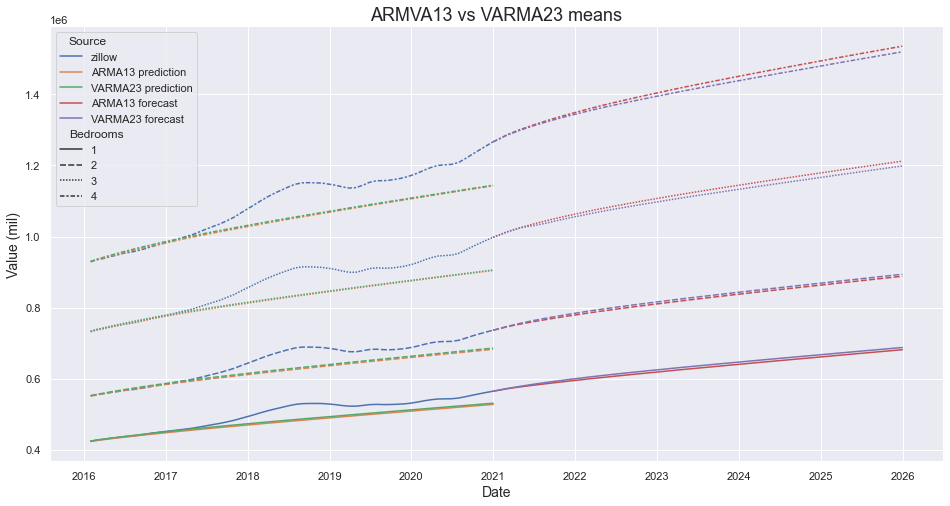

In [41]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = avg_df_sub[avg_df_sub['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("ARMVA13 vs VARMA23 means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('arma13_vs_varma23_mean.png')

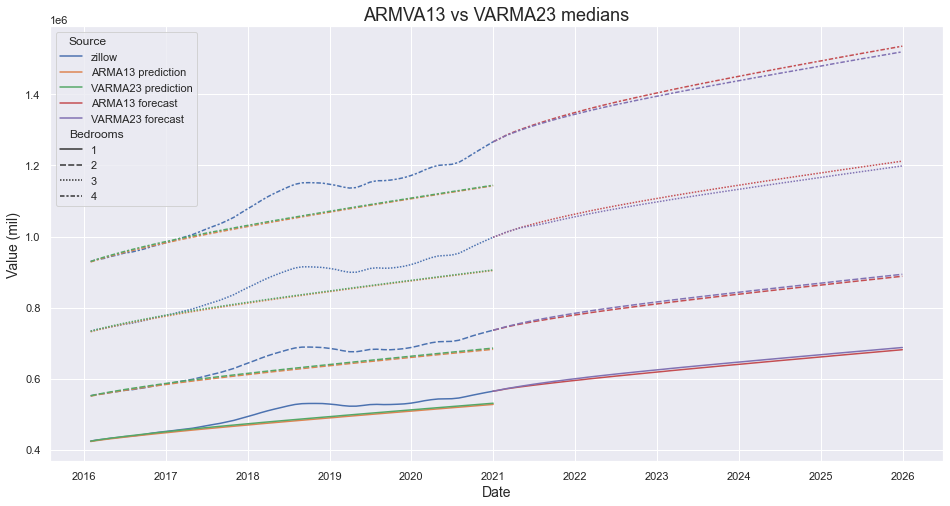

In [42]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_median = avg_df_sub[avg_df_sub['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("ARMVA13 vs VARMA23 medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('arma13_vs_varma23_median.png')

They are almost identical! We should use ARMA model.